# Hierarchically coupled causal models

This notebook showcases how to generate hierarchically coupled causal models. 

In [1]:
# Autoreload extension
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import xarray as xr
import matplotlib as mpl

from causaldynamics.utils import set_rng_seed
from causaldynamics.initialization import initialize_weights, initialize_biases, initialize_x
from causaldynamics.scm import create_scm_graph, get_root_nodes_mask, GrowingNetworkWithRedirection
from causaldynamics.mlp import propagate_mlp
from causaldynamics.systems import solve_system
from causaldynamics.plot import plot_trajectories, animate_3d_trajectories, plot_scm, plot_3d_state

In [3]:
# Set a fixed seed for reproducibility
set_rng_seed(42)

# Increase the animation limit to 50MB
mpl.rcParams['animation.embed_limit'] = 50 * 1024**2 

## Generate data – the convenient way
This is the convenient way of generating data. If you need more flexibility, look at the step by step guide below.

This code will first create an structural causal model. The `create_scm` function returns the adjacency matrix `A` of the SCM, the weights `W` and biasses `b` of all the MLPs located on the nodes and the `root_nodes` that act as temporal system driving functions.

We use this SCM to simulate a system constisting of `num_nodes` for `num_timesteps` and driven by the dynamical systems `system_name` that are located on the root nodes.

At least, we visualize the results.

INFO - Creating SCM with 2 nodes and 3 dimensions each...
INFO - Simulating Lorenz system for 200 timesteps...
INFO - Generating visualizations


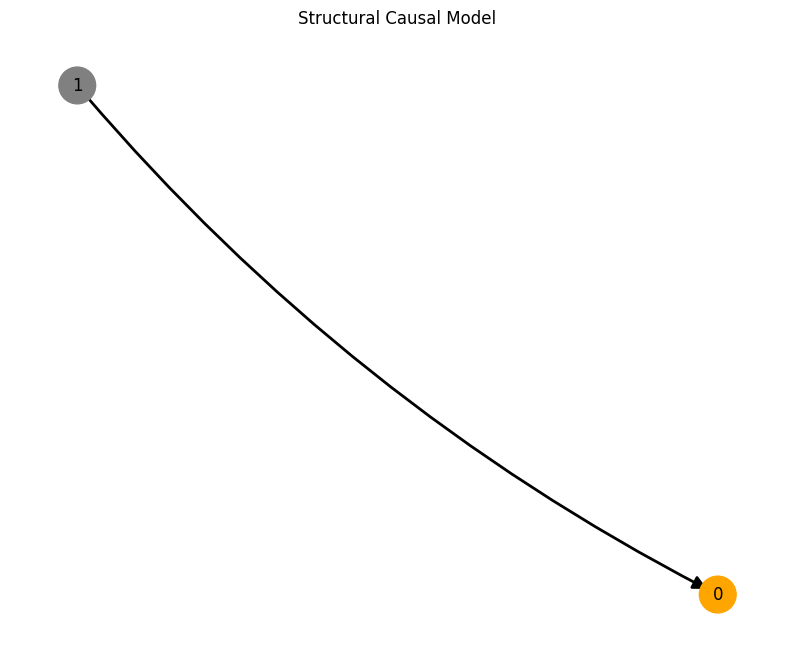

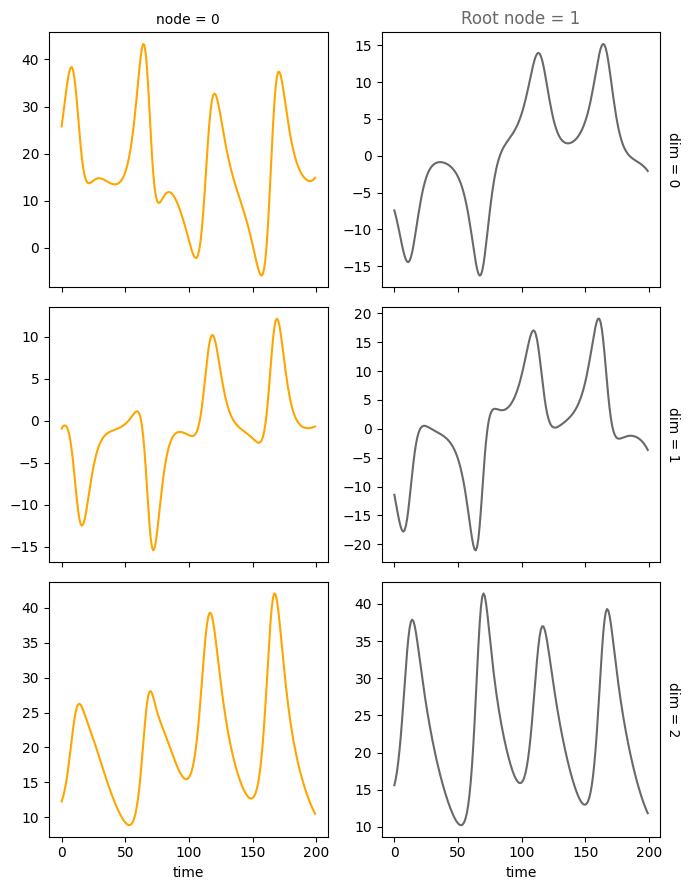

In [4]:
from causaldynamics.creator import create_scm, simulate_system, create_plots

num_nodes = 2
node_dim = 3
num_timesteps = 200

system_name='Lorenz'
confounders = False

A, W, b, root_nodes, _ = create_scm(num_nodes, node_dim, confounders=confounders)

data = simulate_system(A, W, b, 
                      num_timesteps=num_timesteps, 
                      num_nodes=num_nodes,
                      system_name=system_name) 

create_plots(
            data,
            A,
            root_nodes=root_nodes,
            out_dir='.',
            show_plot=True,
            save_plot=False,
            return_html_anim=True,
            create_animation=False,
        )

We provide several features that can be used conveniently accessed through the `create_scm` and `simulate_system` functions:

INFO - Creating SCM with 5 nodes and 3 dimensions each...
INFO - Simulating random system for 500 timesteps...
/Users/herdeanu/kausable/causaldynamics/src/causaldynamics/plot.py:759: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Axes3D: title={'center': 'Node 0'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Node 1'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Node 2'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 3'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 4'}, xlabel='X', ylabel='Y', zlabel='Z'>)

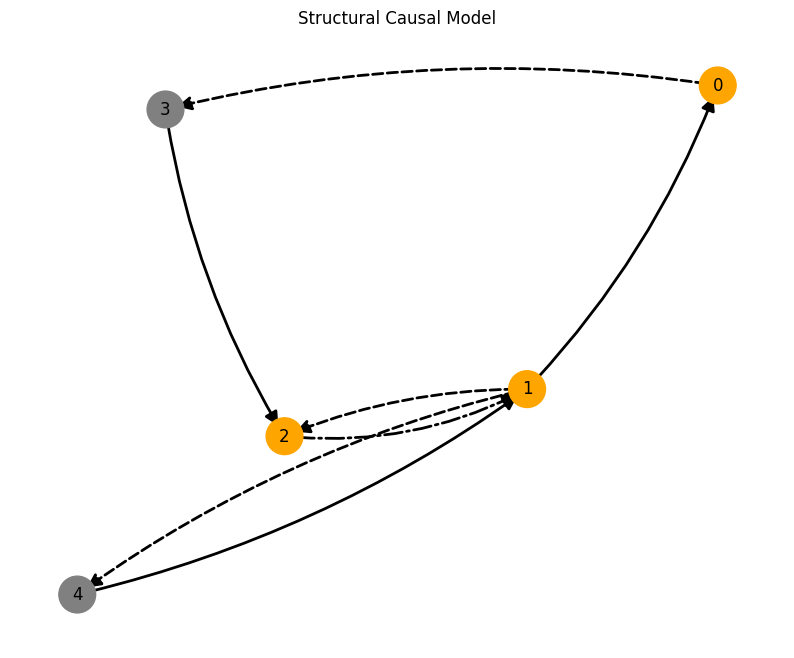

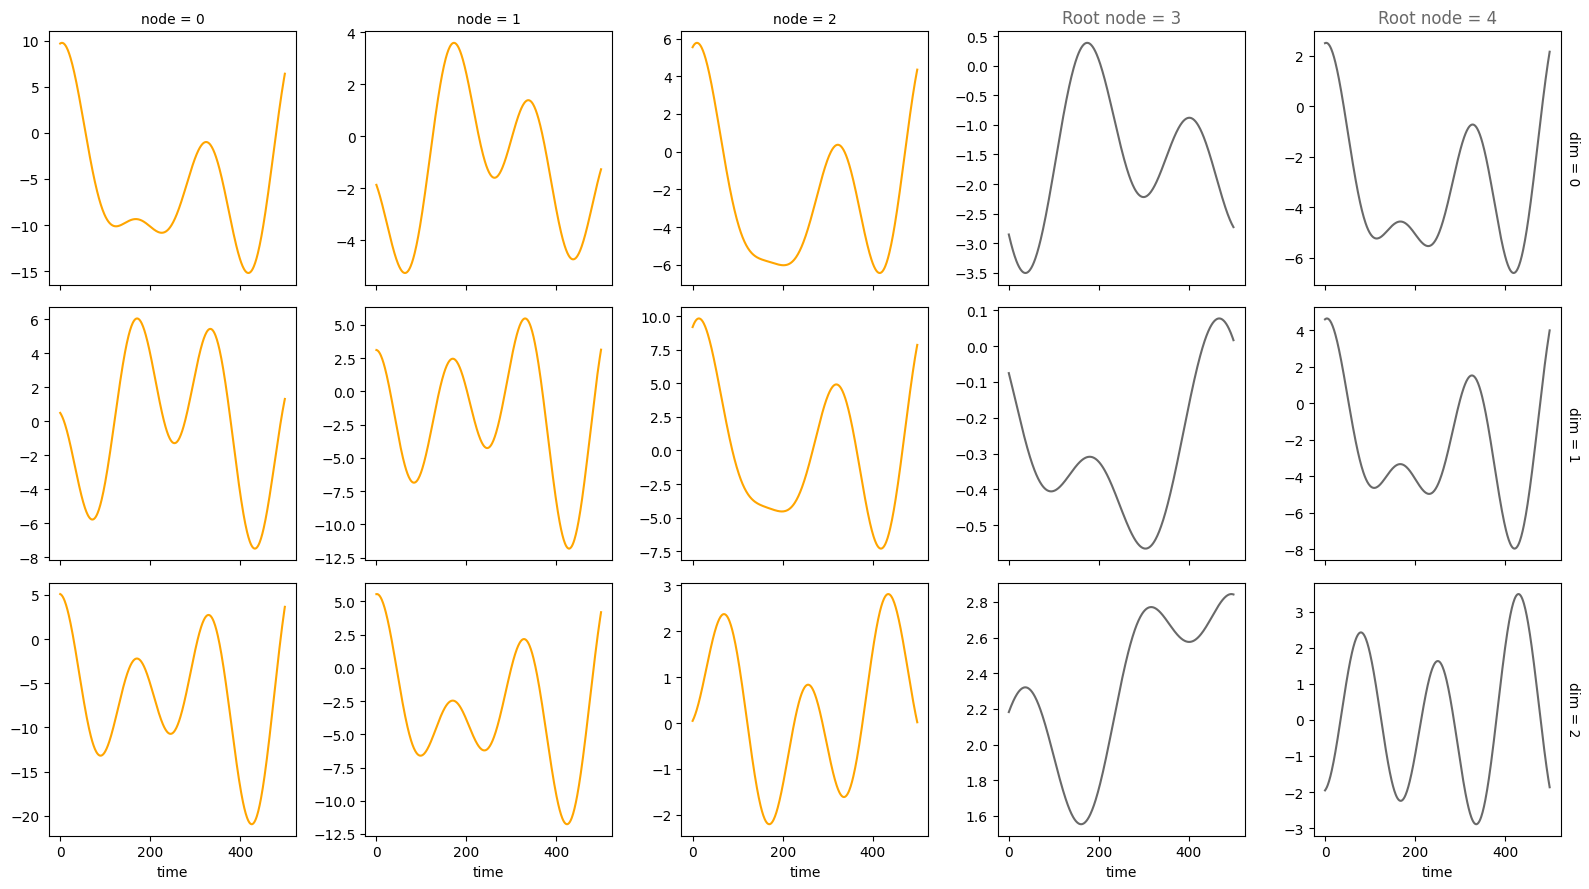

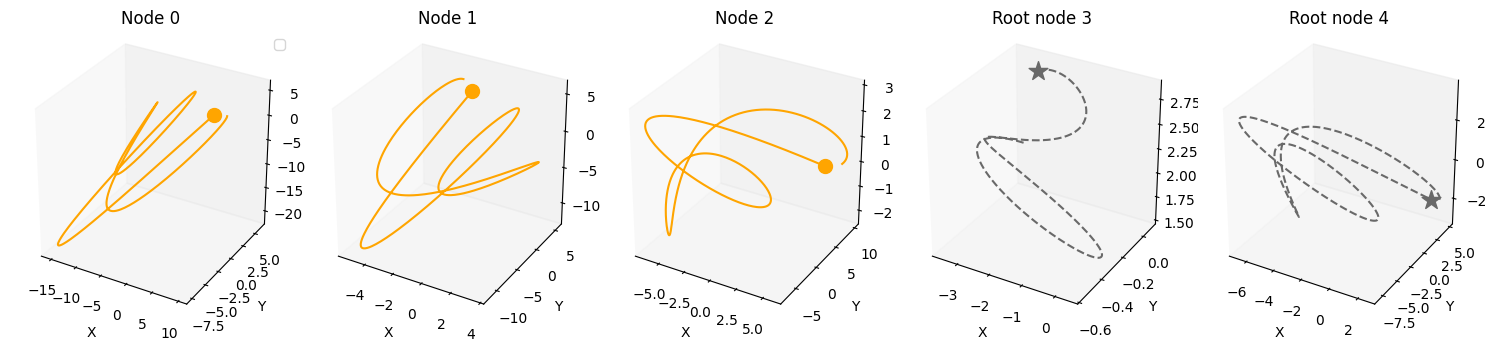

In [5]:
from causaldynamics.creator import create_scm, simulate_system
from causaldynamics.plot import plot_scm, plot_trajectories, plot_3d_state

num_nodes = 5
node_dim = 3
num_timesteps = 500

confounders = False    # set to True to add scale-free confounders
standardize = False    # set to True to standardize the data
init_ratios = [1, 1]   # set ratios of dynamical systems and periodic drivers at root nodes. Here: equal ratio.
system_name='random'   # sample random dynamical system for the root nodes
noise = 0.5            # set noise for the dynamical systems

time_lag = 10                   # set time lag for time-lagged edges
time_lag_edge_probability = 0.1 # set probability of time-lagged edges


A, W, b, root_nodes, _ = create_scm(num_nodes, 
                                    node_dim,
                                    confounders=confounders,
                                    time_lag=time_lag,
                                    time_lag_edge_probability=time_lag_edge_probability)

data = simulate_system(A, W, b, 
                      num_timesteps=num_timesteps, 
                      num_nodes=num_nodes,
                      system_name=system_name,
                      init_ratios=init_ratios,
                      time_lag=time_lag,
                      standardize=standardize,
                      make_trajectory_kwargs={'noise': noise}) 

plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)
plot_trajectories(data, root_nodes=root_nodes, sharey=False)
plot_3d_state(data, root_nodes, line_alpha=1.)

For an overview of the features, have a look at the `feature.ipynb` notebook. If you want more information on specific features, look at their respective notebook, e.g., `driver.ipynb` or `time_lag.ipynb`.

## Detailed step by step explanation

Let's look step-by-step what happens internally in the `create_scm` and `simulate_system` functions. 

Let's create a minimal example with a causal graph that has two nodes 0 and 1 and a single edge 1<-0. The signal we send through that graph is given by a Lorenz attractor with dimension 3 that is calculated for some time steps.

In [6]:
# Define parameters for a small test example
N_nodes = 2
N_timesteps = 1000
N_dimensions = 3

# Generate Lorenz attractor trajectory
d_lorenz = solve_system(N_timesteps, N_nodes, "Lorenz")

In [7]:
# Sample the simplest possible adjacency matrix: 0<--1
A = GrowingNetworkWithRedirection(N_nodes).generate()
A

tensor([[0., 0.],
        [1., 0.]])

In [8]:
# Sample random weights for the MLPs
W = initialize_weights(N_nodes, N_dimensions)
W


tensor([[[-0.2657, -1.0421, -1.8103],
         [-1.6468,  0.9513, -1.7132],
         [ 1.4713, -0.0967,  1.5466]],

        [[ 0.2724,  0.1536, -0.5448],
         [-0.2377, -1.2648,  0.5678],
         [ 1.5151, -1.0185,  1.1759]]])

In [9]:
# Sample random biases for the MLPs
b = initialize_biases(N_nodes, N_dimensions)
b


tensor([[ 1.4435,  1.7959,  0.0942],
        [-1.0453, -1.0797,  2.7330]])

Let's plot the minimal test graph 1<--0 and propagate the Lorenz attractor through the causal graph. 

First, nitialize the root node 1 with the time-series data from the Lorenz attractor. Then, propagate this signal through the edge 1->0. The signal is the input to the sampled multilayer perceptron (MLP) with no activation function. The output is the state of node 0.

(<Axes3D: title={'center': 'Node 0'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 1'}, xlabel='X', ylabel='Y', zlabel='Z'>)

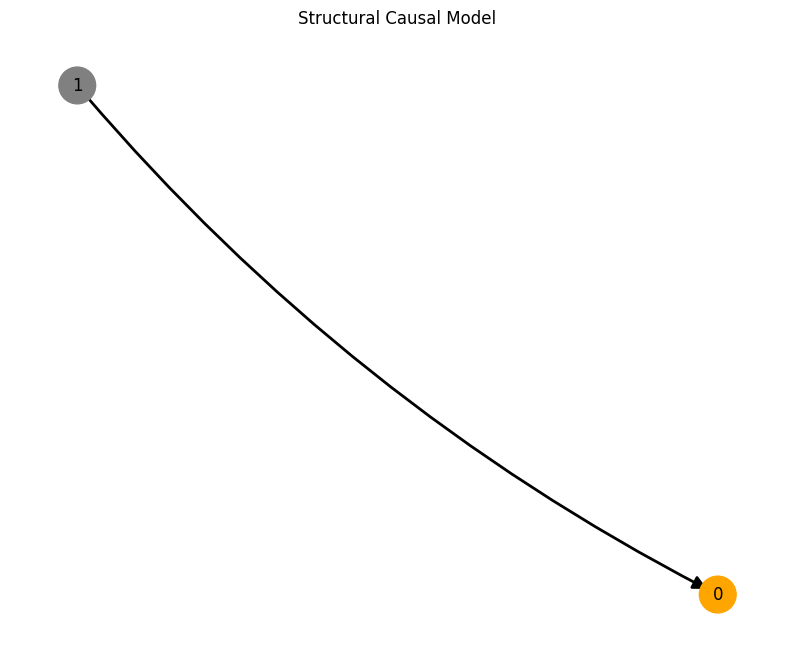

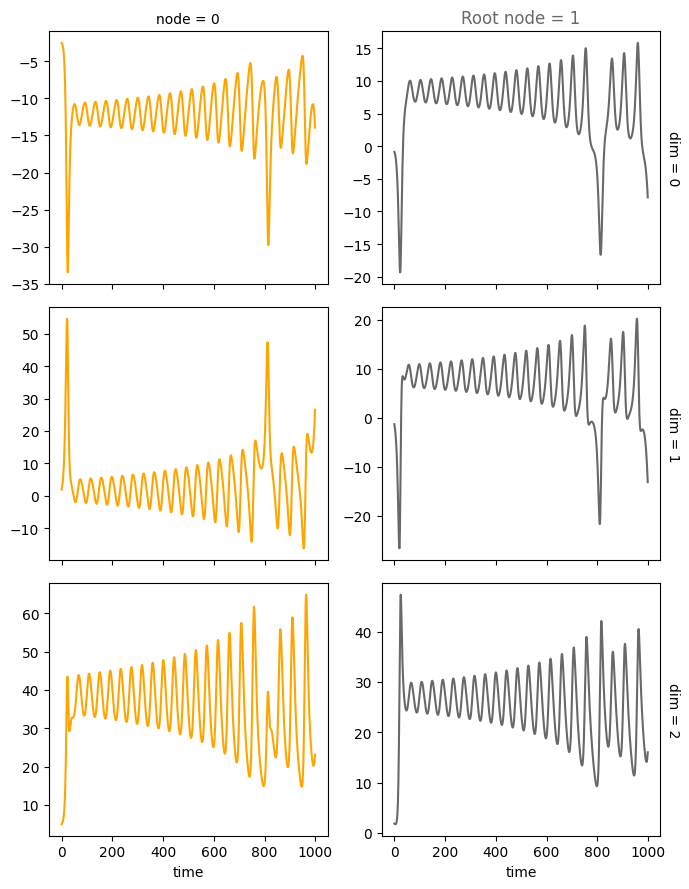

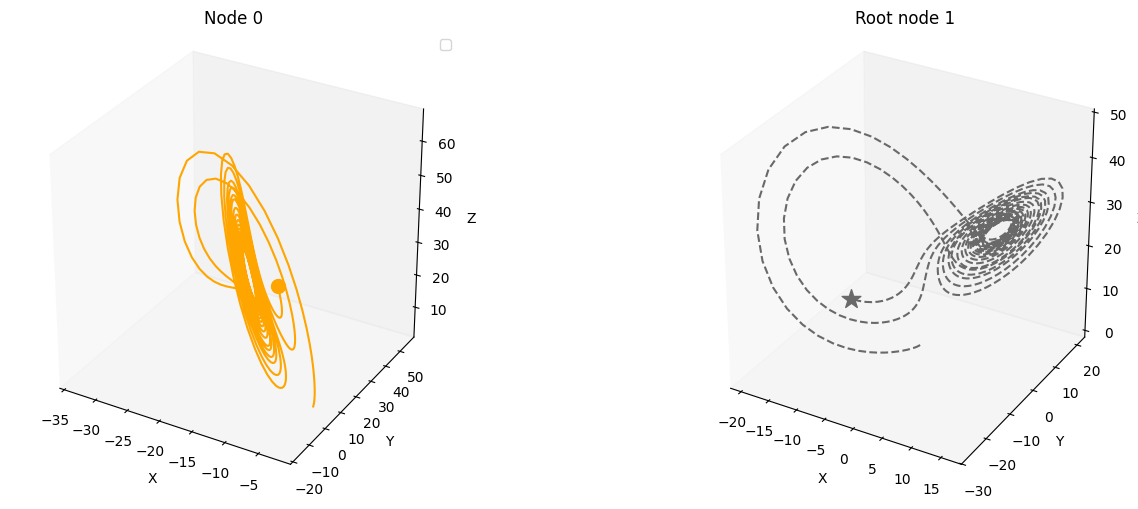

In [10]:
# Initialize the root nodes with the Lorenz attractor
init = initialize_x(d_lorenz, A)

# Propagate Lorenz trajectory through the SCM
x = propagate_mlp(A, W, b, init=init)

# Visualize the results using xarray
data = xr.DataArray(x, dims=['time', 'node', "dim"])
root_nodes = get_root_nodes_mask(A)

plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)
plot_trajectories(data, root_nodes=root_nodes, sharey=False)
plot_3d_state(data, root_nodes, line_alpha=1.)

We can even visualize the time unfolding of the system by creating animations. However, this may take a while to run.

In [ ]:
# Create an animation of the simple coupled Lorenz attractor. 
da_sel = data.isel(time=slice(0, 500))
anim = animate_3d_trajectories(da_sel, frame_skip=2, rotate=True , show_history=True, plot_type='subplots', root_nodes=root_nodes)
display(anim)

### Specify graph structures

You can also provide and explore specific graph structure. Let's say we want to look at the SCM graph 1->0<-2

(<Axes3D: title={'center': 'Node 0'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 1'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 2'}, xlabel='X', ylabel='Y', zlabel='Z'>)

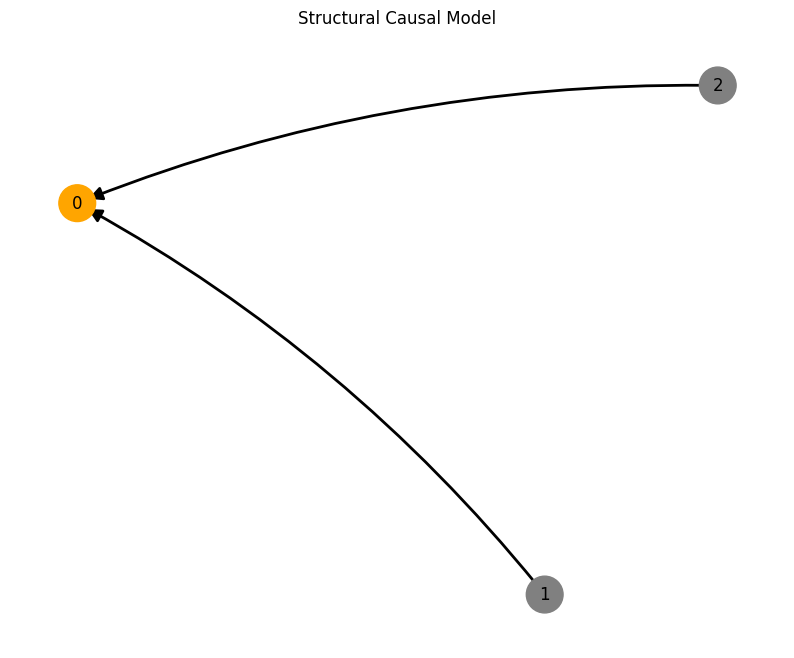

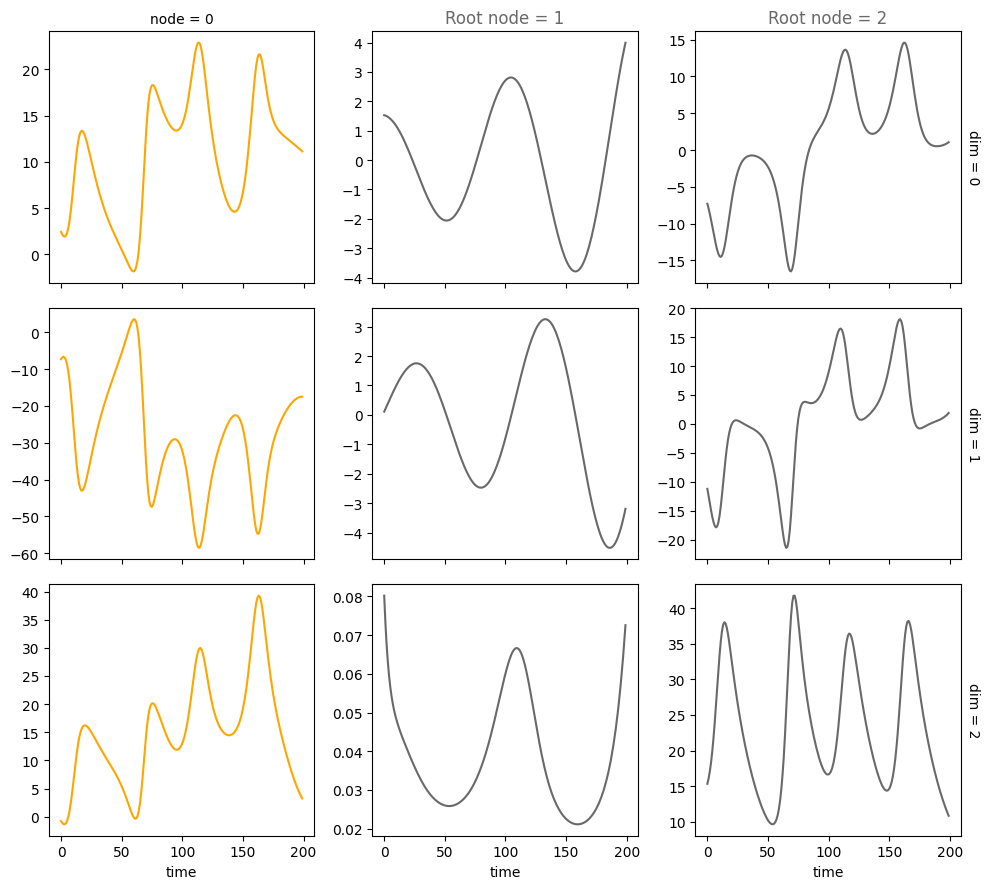

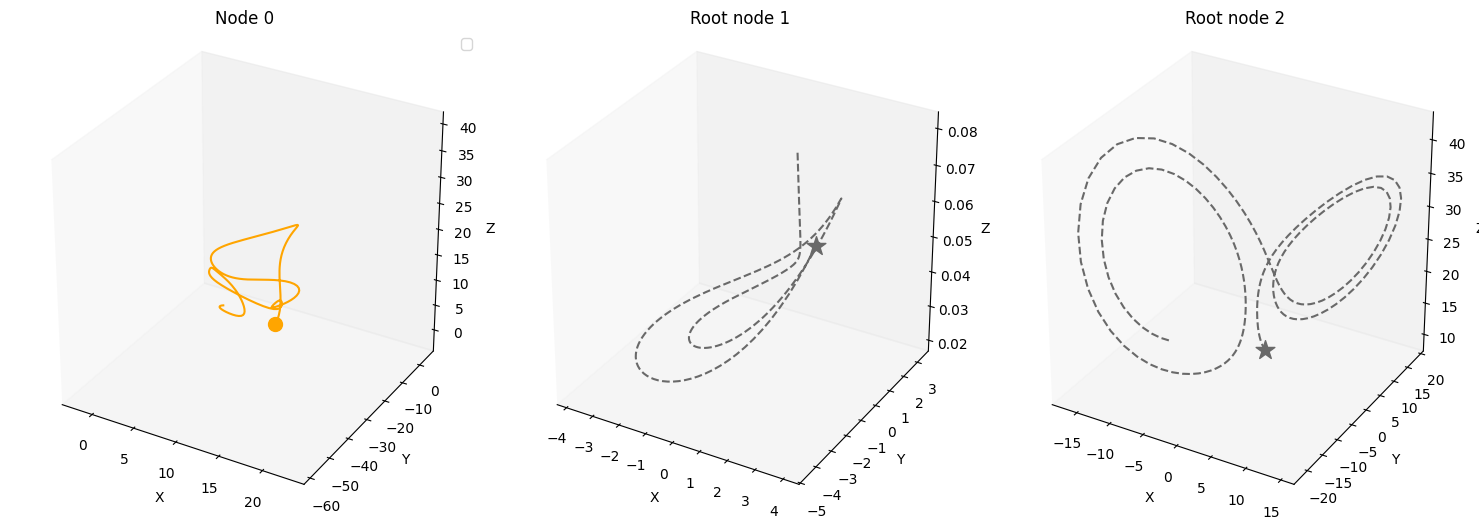

In [11]:
# Set parameters
num_nodes = 3
num_timesteps = 200
dimensions = 3

A = torch.tensor([[0., 0., 0.],
                  [1., 0., 0.],
                  [1., 0., 0.]])
W = initialize_weights(num_nodes, dimensions)
b = initialize_biases(num_nodes, dimensions)
init = solve_system(num_timesteps, num_nodes, "Lorenz")
init2 = solve_system(num_timesteps, num_nodes, "Rossler")
init[:, 1] = init2[:, 1]
init = initialize_x(init, A)
x = propagate_mlp(A, W, b, init=init)
root_nodes = get_root_nodes_mask(A)
data = xr.DataArray(x, dims=['time', 'node', "dim"])

plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)
plot_trajectories(data, root_nodes=root_nodes, sharey=False)
plot_3d_state(data, root_nodes, line_alpha=1.)


Now, we look at a linear chain: 2->1->0

(<Axes3D: title={'center': 'Node 0'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Node 1'}, xlabel='X', ylabel='Y', zlabel='Z'>,
 <Axes3D: title={'center': 'Root node 2'}, xlabel='X', ylabel='Y', zlabel='Z'>)

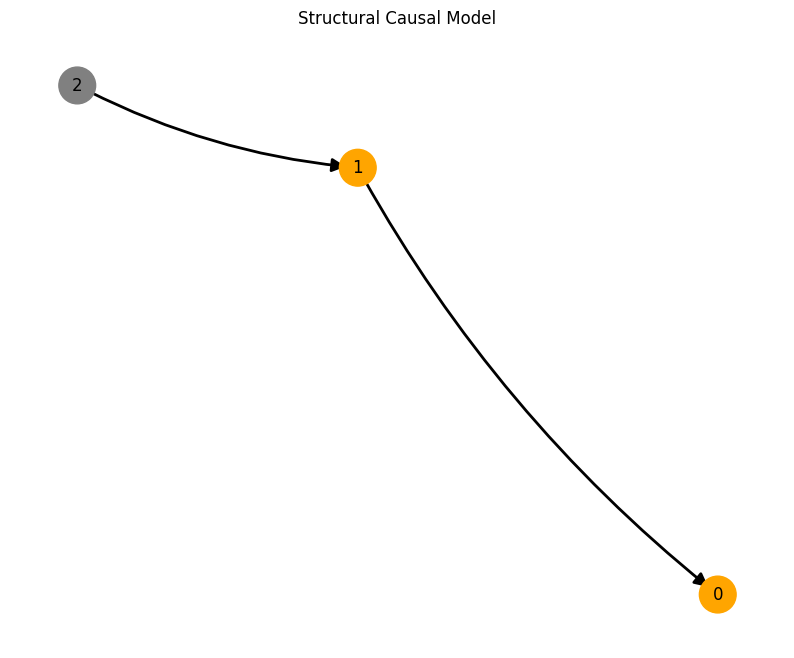

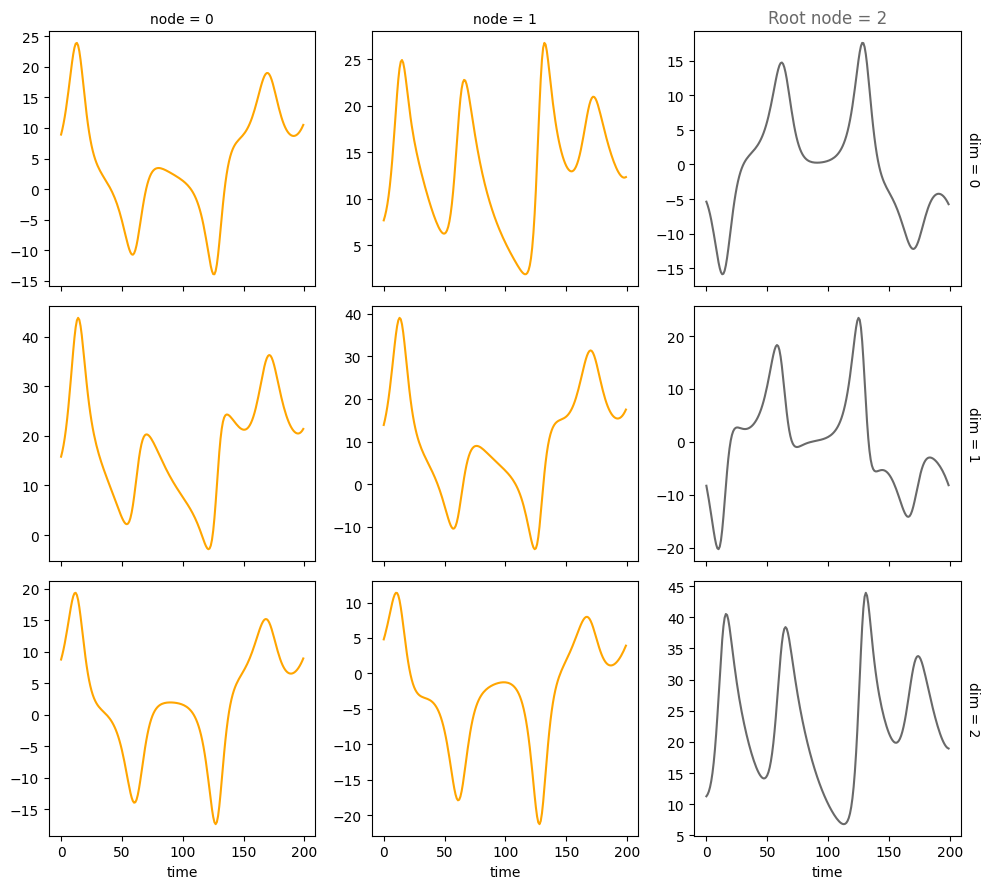

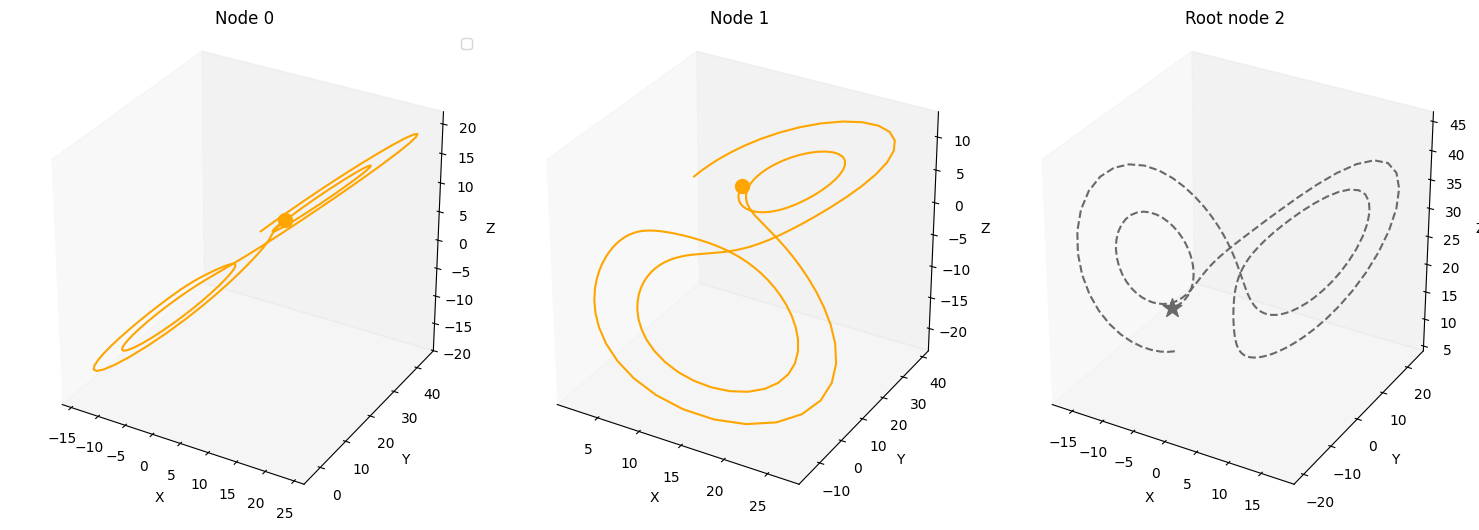

In [12]:
# Sample the SCM, all hyperoparameters and propagate the Lorenz attractor through the SCM
A = torch.tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
W = initialize_weights(num_nodes, dimensions)
b = initialize_biases(num_nodes, dimensions)
init = solve_system(num_timesteps, num_nodes, "Lorenz")
init = initialize_x(init, A)
x = propagate_mlp(A, W, b, init=init)
root_nodes = get_root_nodes_mask(A)
data = xr.DataArray(x, dims=['time', 'node', "dim"])

plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)
plot_trajectories(data, root_nodes, sharey=False)
plot_3d_state(data, root_nodes, line_alpha=1.)